# Modelling Notebook for Rob's Sleep Schedule

In [51]:
import pandas as pd
import numpy as np
from plotnine import *

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import config_context

pd.set_option('display.max.columns', 500)

Mandatory 'bruh' for the amount of imports in Python:

<img src="https://i.ytimg.com/vi/8MOtth7Vln8/hqdefault.jpg" alt="drawing" width="250"/>

In [7]:
# Import data 
train = pd.read_csv("Data/train_prepped_final.csv")
test = pd.read_csv("Data/test_prepped_final.csv")

As the test doesn't containt the true target, split train further into test and train:

In [35]:
X, y = train.drop(['sleep_hours', 'date'], axis=1), train.sleep_hours

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [37]:
X_train.shape

(1765, 79)

In [38]:
X_test.shape

(589, 79)

In [39]:
# Convert objects to categories
for dataset in [X_train, X_test]:
    for col in dataset.select_dtypes(include="object").columns:
        dataset[col] = dataset[col].astype("category")

### Modelling LGBM

In [43]:
# Making column selectors for dtypes
num_cols = make_column_selector(dtype_include="number")
cat_cols = make_column_selector(dtype_exclude="number")

# Making pipelines for column transformer
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("encoder", OneHotEncoder(max_categories=30,
                              handle_unknown='ignore')),
])

# Making column transformer
preprocessor = ColumnTransformer(
    transformers=[("numeric", numeric_transformer, num_cols),
                  ("categorical", categorical_transformer, cat_cols)],
    remainder="passthrough"
)

# Making model pipeline for lightgbm
lgbm_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("LGBMmodel", LGBMRegressor())
])

In [44]:
# see transformed dataset
pd.DataFrame(lgbm_pipeline[:-1].fit_transform(X_train, y_train),
             columns=lgbm_pipeline[:-1].get_feature_names_out())


,numeric__active_energy,numeric__exercise_minutes,numeric__HKCategoryValueAppleStandHourIdle,numeric__HKCategoryValueAppleStandHourStood,numeric__HKCategoryValueEnvironmentalAudioExposureEventMomentaryLimit,numeric__minutes_stood,numeric__basal_energy,numeric__body_mass,numeric__body_mass_index,numeric__distance_walking_running,numeric__env_audio_exposure_min,numeric__env_audio_exposure_mean,numeric__env_audio_exposure_median,numeric__env_audio_exposure_max,numeric__flights_climbed,numeric__headphone_audio_exposure_min,numeric__headphone_audio_exposure_mean,numeric__headphone_audio_exposure_median,numeric__headphone_audio_exposure_max,numeric__heartrate_min,numeric__heartrate_mean,numeric__heartrate_median,numeric__heartrate_max,numeric__heartrate_var_min,numeric__heartrate_var_mean,numeric__heartrate_var_median,numeric__heartrate_var_max,numeric__oxygen_saturation_min,numeric__oxygen_saturation_mean,numeric__oxygen_saturation_median,numeric__oxygen_saturation_max,numeric__respiratory_rate_min,numeric__respiratory_rate_mean,numeric__respiratory_rate_median,numeric__respiratory_rate_max,numeric__resting_heartrate,numeric__stair_ascent_speed_min,numeric__stair_ascent_speed_mean,numeric__stair_ascent_speed_median,numeric__stair_ascent_speed_max,numeric__stair_descent_speed_min,numeric__stair_descent_speed_mean,numeric__stair_descent_speed_median,numeric__stair_descent_speed_max,numeric__step_count,numeric__vo2_max,numeric__walking_asymmetry_min,numeric__walking_asymmetry_mean,numeric__walking_asymmetry_median,numeric__walking_asymmetry_max,numeric__walking_support_min,numeric__walking_support_mean,numeric__walking_support_median,numeric__walking_support_max,numeric__walking_heartrate_mean,numeric__walking_speed_min,numeric__walking_speed_mean,numeric__walking_speed_median,numeric__walking_speed_max,numeric__walking_steplength_min,numeric__walking_steplength_mean,numeric__walking_steplength_median,numeric__walking_steplength_max,numeric__year,numeric__month,numeric__dom,numeric__doy,numeric__week,numeric__dow,numeric__quarter,numeric__is_holiday,numeric__target_lag_1,numeric__target_lag_2,numeric__target_lag_3,numeric__target_lag_4,numeric__target_lag_5,numeric__target_lag_6,numeric__target_lag_7,categorical__holiday_Christmas Day,categorical__holiday_Christmas Day (Observed),categorical__holiday_Columbus Day,categorical__holiday_Independence Day,categorical__holiday_Independence Day (Observed),categorical__holiday_Juneteenth National Independence Day (Observed),categorical__holiday_Labor Day,categorical__holiday_Martin Luther King Jr. Day,categorical__holiday_Memorial Day,categorical__holiday_New Year's Day,categorical__holiday_New Year's Day (Observed),categorical__holiday_No Holiday,categorical__holiday_Thanksgiving,categorical__holiday_Veterans Day,categorical__holiday_Veterans Day (Observed),categorical__holiday_Washington's Birthday
0,3.216281,-0.121028,0.064891,-0.131511,-0.073621,-0.072117,-0.441926,-1.484730,-1.593194,1.065438,0.044846,-0.036090,0.003382,-0.061520,2.166808,0.170272,0.040549,0.079928,0.103366,-0.032111,-0.071543,-0.067374,0.095356,-0.028910,-0.046117,-0.040934,-0.067249,0.180295,0.006728,-0.112238,0.202209,0.014315,-0.020424,0.009451,-0.009138,-0.078877,-0.146008,-0.087153,-0.049594,-0.026114,-0.132359,-0.097967,-0.101073,0.022079,1.535047,0.110830,0.0,-0.182932,-0.056158,-0.209994,0.004117,-0.028538,-0.027964,-0.001048,-0.011440,-0.024819,0.072657,0.073491,-0.044405,-0.022070,0.033814,0.039357,-0.023703,-1.663359,0.658081,1.302630,0.765026,0.763282,1.494870,0.374028,-0.175949,0.865114,0.399751,-0.575251,-0.653581,0.106796,0.376096,0.074934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.166019,-0.121028,0.064891,-0.131511,-0.073621,-0.072117,-0.374077,1.365559,1.479003,-0.049670,0.044846,-0.036090,0.003382,-0.061520,0.422809,0.170272,0.040549,0.079928,0.103366,-0.032111,-0.071543,-0.067374,0.095356,-0.028910,-0.046117,-0.040934,-0.067249,0.180295,0.006728,-0.112238,0.202209,0.014315,-

In [48]:
# Create the random grid
# Important: Put the Name of the model from the pipeline including two backspaces
# before the parameter names in the dictionary
lgbm_grid = {
    'LGBMmodel__num_leaves': [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096],
    'LGBMmodel__max_depth': [int(x) for x in np.linspace(start=1, stop=100, num=20)],
    'LGBMmodel__learning_rate' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5],
    'LGBMmodel__subsample' : [0.4, 0.6, 0.8, 1]
}

lgbm_search = (RandomizedSearchCV(lgbm_pipeline, param_distributions=lgbm_grid, n_iter=200,
                                  verbose=1, cv=3, scoring="neg_root_mean_squared_error")
               .fit(X_train, y_train))

Fitting 3 folds for each of 200 candidates, totalling 600 fits


In [49]:
# Select the hyperparams and the score from the results
lgbm_search_results = (pd.DataFrame(lgbm_search.cv_results_)
                       .filter(["param_" + x for x in list(lgbm_grid.keys())] + ["mean_test_score"]))

# Clean up column headers
lgbm_search_results.columns = lgbm_search_results.columns.str.replace("param_LGBMmodel__", "")

# lgbm_search_results.sort_values("mean_test_score", ascending=False)
lgbm_search_results.describe()


,mean_test_score
count,200.000000
mean,-0.960249
std,0.053799
min,-1.090201
25%,-0.955239
50%,-0.934631
75%,-0.931081
max,-0.923888


In [52]:
# Print the metrics for LGBM
print("LGBM Final Fit Metrics:")
print("--------------------------------")
print(f"R-Squared: {r2_score(y_pred=lgbm_search.predict(X_test), y_true=y_test)}")
print(f"MAE: {mean_absolute_error(y_pred=lgbm_search.predict(X_test), y_true=y_test)}")
print(f"MAPE: {mean_absolute_percentage_error(y_pred=lgbm_search.predict(X_test), y_true=y_test)}")
print(f"RMSE: {mean_squared_error(y_pred=lgbm_search.predict(X_test), y_true=y_test, squared=False)}")


LGBM Final Fit Metrics:
--------------------------------
R-Squared: 0.05210157612918165
MAE: 0.6297058829484246
MAPE: 0.09756608763552328
RMSE: 0.8424534676833474


In [55]:
pd.DataFrame({"predictions": lgbm_search.predict(X_test),
                   "truth": y_test,
                   "model": "XGBoost"})

,predictions,truth,model
2209,6.674860,5.675000,XGBoost
2122,6.710447,7.483333,XGBoost
1140,6.781433,6.933333,XGBoost
489,6.567454,6.833333,XGBoost
1174,6.812127,6.050000,XGBoost
...,...,...,...
85,6.649090,6.550000,XGBoost
202,6.859840,4.233333,XGBoost
15,6.680942,7.433333,XGBoost
474,6.603909,6.100000,XGBoost


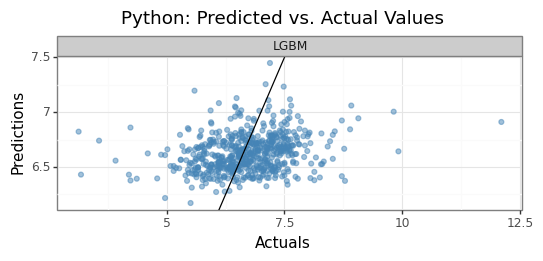

<ggplot: (166884673080)>

In [57]:
p = (
    ggplot(data=(pd.DataFrame({"predictions": lgbm_search.predict(X_test),
                               "truth": y_test,
                               "model": "LGBM"})),
           mapping=aes(x="truth", y="predictions")) +
    geom_point(colour="#4584b6", alpha=0.5) +
    geom_abline() +
    labs(title="Python: Predicted vs. Actual Values",
         y="Predictions", x="Actuals") +
    facet_wrap("~ model") +
    theme_bw() +
    theme(figure_size=[6, 2])
)

p


In [60]:
best_model_params = lgbm_search.best_params_
best_model_params

{'LGBMmodel__subsample': 0.6,
 'LGBMmodel__num_leaves': 2,
 'LGBMmodel__max_depth': 27,
 'LGBMmodel__learning_rate': 0.1}

In [68]:
X_full = train.drop(['sleep_hours', 'date'], axis=1)
y_full = train.sleep_hours

final_lgbm_model = lgbm_pipeline.fit(X, y)

In [77]:
holdout = test.drop(['sleep_hours', 'date'], axis=1)

submission = pd.DataFrame({'date': pd.to_datetime(test.date),
                           'sleep_hours': final_lgbm_model.predict(holdout)})

submission

,date,sleep_hours
0,2022-01-01,7.357845
1,2022-01-02,6.623198
2,2022-01-03,6.656466
3,2022-01-04,6.812700
4,2022-01-05,6.868703
...,...,...
414,2023-03-12,6.731343
415,2023-03-13,6.183214
416,2023-03-14,7.238870
417,2023-03-15,6.499559


In [79]:
submission.to_csv("Predictions/lgbm.csv", index=False)

### Modelling Neural Network

TBD:
- XGBoost
- Neural Network with Pytorch

